In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

from keras.models import model_from_json
import cv2, os
from keras.layers import Flatten
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
train_dir = r"dataset/ImageEmotion (85-15)/train"
test_dir = r"dataset/ImageEmotion (85-15)/test"

SEED = 12
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 128
momentum = 0.9
EPOCHS = 500
#FINE_TUNING_EPOCHS = 30
LR = 0.001
NUM_CLASSES = 8
EARLY_STOPPING_CRITERIA=3
CLASS_LABELS  = ['Amusement', 'Anger', 'Awe', 'Contentment', 'Disgust', 'Excitement', 'Fear', 'Sadness']
CLASS_LABELS_EMOJIS = ["🥳", "😡", "😯", "😌", "🤢" ,"🤩", "😱" , "😔" ]

In [4]:
#loading image data
train_imagedata_preprocessed = np.load(r'FeatureFiles/MobileNet_train_imagedata.npy', mmap_mode='r')
print('Loaded train image data preprocessed')
test_imagedata_preprocessed = np.load(r'FeatureFiles/MobileNet_test_imagedata.npy', mmap_mode='r')
print('Loaded test image data preprocessed')
train_MainObject = np.load(r'FeatureFiles/MobileNet_train_MainObject.npy')
print('Loaded train main object data')
test_MainObject = np.load(r'FeatureFiles/MobileNet_test_MainObject.npy')
print('Loaded test main object data')
train_category = np.load(r'FeatureFiles/MobileNet_train_Category.npy')
print('Loaded train Category')
test_category = np.load(r'FeatureFiles/MobileNet_test_Category.npy')
print('Loaded test Category')

train_labels = np.load(r'FeatureFiles/train_labels.npy')
print('Loaded train labels')
test_labels = np.load(r'FeatureFiles/test_labels.npy')
print('Loaded test labels')

Loaded train image data preprocessed
Loaded test image data preprocessed
Loaded train main object data
Loaded test main object data
Loaded train Category
Loaded test Category
Loaded train labels
Loaded test labels


In [6]:
train_data = ((train_MainObject, train_imagedata_preprocessed, train_category), train_labels)
test_data = tf.data.Dataset.from_tensor_slices(((test_MainObject,test_imagedata_preprocessed,
                                                test_category), test_labels))

test_data = test_data.batch(BATCH_SIZE)

In [7]:
data_augmentation = tf.keras.Sequential([
                            tf.keras.layers.RandomFlip('horizontal'),
                            tf.keras.layers.RandomRotation(1./36),
                            tf.keras.layers.RandomHeight(0.05),
                            tf.keras.layers.RandomWidth(0.1)
                            ])

In [8]:
class Custom_DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size, shuffle, augmentation):
        self.batch_size = batch_size
        self.data = data
        self.indices = [i for i in range(len(data[0][0]))]
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.on_epoch_end()
        
    def __len__(self):
        return len(self.indices) // self.batch_size
    
    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)
    
    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index+1) * self.batch_size]
        batch = [self.indices[k] for k in index]
        
        X, y = self.__get_data(batch)
        return X, y
        
    def __get_data(self, batch):
        X1 = np.zeros(shape=(128,1024))
        X2 = np.zeros(shape=(128,224,224,3))
        X3 = np.zeros(shape=(128,1024))
        y = np.zeros(shape=(128,8))
        
        for i,ID in enumerate(batch):
            X1[i] = self.data[0][0][ID]
            X2[i] = self.data[0][1][ID]
            X3[i] = self.data[0][2][ID]
            y[i] = self.data[1][ID]
            
        X = (X1, self.augmentation(X2), X3)
        
        return X, y

In [9]:
train_datagen = Custom_DataGenerator(train_data, 128, True, data_augmentation)

In [10]:
basee_model = tf.keras.applications.mobilenet.MobileNet(input_shape=(224,224,3), include_top=False,
                                                weights= 'imagenet')

def base_model_feature_extractor(inputs):
    y = basee_model(inputs)
    y = tf.keras.layers.GlobalAveragePooling2D()(y)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(y)
    
    return x, y

def classifier(features):
    #x = tf.keras.layers.GlobalAveragePooling2D()(features)
#     x = tf.keras.layers.Dense(1500, activation='relu', 
#                               kernel_regularizer= tf.keras.regularizers.l2(0.001))(features)
#     x = tf.keras.layers.Dense(500, activation='relu', 
#                               kernel_regularizer= tf.keras.regularizers.l2(0.01))(x)
#     x = tf.keras.layers.Dense(100, activation='relu', 
#                               kernel_regularizer= tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', 
                              #kernel_regularizer= tf.keras.regularizers.l2(0.01),
                              name='classification')(features)
    
    return x
        
def final_model(inputs1, inputs2, inputs3, base_model):
    x, CNN_features = base_model(inputs2)
    merged_features = tf.concat([inputs1, CNN_features, inputs3], axis=1)
    classification_output = classifier(merged_features)
    
    return classification_output

def define_compile_model(baseweights_path):
    
    inputs1 = tf.keras.layers.Input(shape=(1024,))
    inputs2 = tf.keras.layers.Input(shape=(224,224,3))
    inputs3 = tf.keras.layers.Input(shape=(1024,))
    #base_model = Load_Model(basemodel_path, baseweights_path)
    base_model = tf.keras.Model(inputs= inputs2, outputs= base_model_feature_extractor(inputs2))
    base_model.load_weights(baseweights_path)
    #base_model.layers[-1].trainable = False
    classification_output = final_model(inputs1, inputs2, inputs3, base_model) 
    model = tf.keras.Model(inputs= [inputs1,inputs2,inputs3], outputs= classification_output)
    model.compile(optimizer=tf.keras.optimizers.SGD(0.001), 
                loss='categorical_crossentropy',
                metrics = ['acc'])
  
    return model

In [11]:
baseweights_path = r'h5 files/MobileNet-025-0.726925-0.605737.h5'
model = define_compile_model(baseweights_path)
#model.load_weights(r'MobileNetV2_CNN+Sem+LF-004-0.691902-0.577052.h5')

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 1024)]       0           []                               
                                                                                                  
 model (Functional)             ((None, 8),          3237064     ['input_3[0][0]']                
                                 (None, 1024))                                                    
                                                                                            

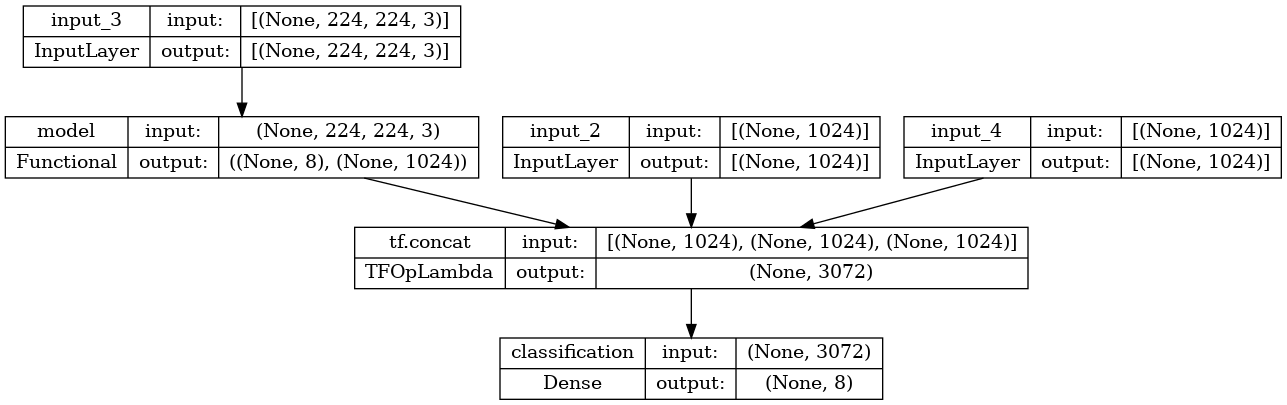

In [12]:
#for plotting model
import keras.utils.vis_utils
from importlib import reload
reload(keras.utils.vis_utils)


from keras.utils.vis_utils import plot_model    
plot_model(model, to_file='model_i1.png', show_shapes=True, show_layer_names=True)

In [13]:
#for saving weights after every epoch
checkpoint = ModelCheckpoint('LiteEmote-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, 
                        monitor='val_acc',save_best_only=True, mode='auto') 
#earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='auto')

In [14]:
#training the model
history = model.fit(train_datagen,
            batch_size = BATCH_SIZE,
            epochs= 100,
            validation_data = test_data,
            callbacks= [checkpoint]
            )

history = pd.DataFrame(history.history)

Epoch 1/100
144/144 [==============================] - ETA: 0s - loss: 1.7352 - acc: 0.3764
Epoch 1: val_acc improved from -inf to 0.44858, saving model to LiteEmote-001-0.376356-0.448581.h5
144/144 [==============================] - 339s 2s/step - loss: 1.7352 - acc: 0.3764 - val_loss: 1.5813 - val_acc: 0.4486
Epoch 2/100
144/144 [==============================] - ETA: 0s - loss: 1.4313 - acc: 0.4966
Epoch 2: val_acc improved from 0.44858 to 0.48795, saving model to LiteEmote-002-0.496582-0.487946.h5
144/144 [==============================] - 337s 2s/step - loss: 1.4313 - acc: 0.4966 - val_loss: 1.4467 - val_acc: 0.4879
Epoch 3/100
144/144 [==============================] - ETA: 0s - loss: 1.3163 - acc: 0.5356
Epoch 3: val_acc improved from 0.48795 to 0.50076, saving model to LiteEmote-003-0.535645-0.500763.h5
144/144 [==============================] - 336s 2s/step - loss: 1.3163 - acc: 0.5356 - val_loss: 1.3815 - val_acc: 0.5008
Epoch 4/100
144/144 [==============================] - 

KeyboardInterrupt: 